In [6]:
import ollama
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import json
import os

#removable
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm

class SentimentClassifier:

    def __init__(self):
        self.model = AutoModelForSequenceClassification.from_pretrained('model')
        self.tokenizer = AutoTokenizer.from_pretrained('tokenizer')
        self.action_dict = {
            1: 'Positive',
            2: 'Slightly Positive',
            3: 'Moderately Negative',
            4: 'Strongly Negative',
            5: 'Extremly Negative'
        }
        self.class_dict = {
            1: 'Category 1',
            2: 'Category 2',
            3: 'Category 3',
            4: 'Category 4',
            5: 'Category 5'
        }

    def preprocess(self, text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)

    def get_sentiment_from_roberta(self, text):
        encoded_input = self.tokenizer(text, return_tensors='pt')
        output = self.model(**encoded_input)
        scores = output[0][0].detach().numpy()
        # scores = output[0][0].cpu().detach().numpy()
        scores = softmax(scores)
        predicted_category = np.argmax(scores)
        return predicted_category
    
    def get_sentiment(self, text):
        cleaned_text = self.preprocess(text)
        prompt = f"""
        You are a language model that classifies text into one of the five categories based on tone and offensiveness.

        Categories:
        1 - Safe and Positive: Statements that are friendly, cheerful, or optimistic. Includes joy, encouragement, harmless fun, or clearly positive experiences.
        2 - Neutral or Slightly Negative: Statements with a neutral tone, mild criticism, or ambivalence. May include mixed feelings (e.g. "I like it, but...") or casual remarks without strong emotion.
        3 - Content with a moderate level of offensiveness. Tone is rude, angry, or sarcastic. May contain insults or profanity out of frustration (e.g. calling someone an "idiot" or saying "this is bullshit"), **but no hate slurs or explicit threats** of violence.
        4 - Content with a high level of offensiveness or hate. Tone is extremely aggressive, angry, or hateful. Often includes strong profanity and **slurs or very derogatory insults** targeting a person or group. May express hateful views or minor threats (e.g. using a slur or saying "I hate you all" with aggression), **but not an explicit serious violent threat**.
        5 - Content that is extremely offensive, violent, or harmful. Tone is extremely hostile or malicious. Contains **explicit threats of severe violence**, or encouragement of heinous acts, or extremely hateful language (e.g. threats to kill, rape, or harm someone, or multiple hate slurs and calls for violence).

        Examples:
        Text: "Don't be a dick. We're all going out on Friday!"
        Category: 3

        Text: "Only f**gots block people."
        Category: 4

        Text: "I will chop your fucking head off if you speak to me like that again."
        Category: 5

        Now determine the correct category for the new text.

        Text: "{cleaned_text}"

        Respond with only a single integer: 1, 2, 3, 4, or 5.
        """

        # prompt = f"""
        # Classify the toxicity of the given text into one of these categories (3, 4, 5):
        # 3 - Harassment/Profanity (no hate or threat): Offensive insults or profanity **without** slurs against protected groups and **no** threats. Example: "You're an idiot, get lost."
        # 4 - Hate Speech (derogatory slurs, no explicit violence): Attacks on someone identity (race, gender, etc.) using slurs or extreme insults **without** threatening harm. Example: "Get out of here, you filthy [slur]."
        # 5 - Violent Threat (explicit harm or calls for violence): Explicit threats or wishes of violence/harm toward someone or a group. Any statement of intent to injure or kill. Example: "I will kill you, you [slur]."

        # Text: "{cleaned_text}"

        # Respond with only a single integer: 3, 4, or 5.
        # """
        
        response = ollama.chat(model="gemma3:12b", messages=[{"role": "user", "content": prompt}])
        try:
            classified_category = int(response["message"]["content"].strip())
        except ValueError:
            classified_category = self.get_sentiment_from_roberta(cleaned_text)
            
        return classified_category 

    def predict(self, text):
        flag = int(self.get_sentiment(text))
        category = self.class_dict[flag]
        action = self.action_dict[flag]

        return flag, category, action
    

class Reasoner:
    def __init__(self, text, file_path):
        self.text = self.preprocess(text)
        self.offense_types_str = json.dumps(json.load(open(file_path, 'r')), indent=4)

    def generate_response(self):
        prompt = f"""
        Match the given negative statement with one of the given categories and give reason in strictly <50 words:
        - Statement: {self.text}
        - Categories: {self.offense_types_str}
        """
        
        response = ollama.chat(model="gemma3:12b", messages=[{"role": "user", "content": prompt}])
        return response["message"]["content"].strip() 
    


In [7]:
def test_on_df(classifier):
    df = pd.read_csv('./data/shimmy/cleaned.csv')
    # df = df[df['Category'].isin([3, 4, 5])]

    y = df['Category']
    preds = []

    for index, row in tqdm(df.iterrows(), desc='Processing: ', total=len(df)):
        text = row['Text']
        flag, category, action = classifier.predict(text)
        preds.append(flag)

    acc_score = accuracy_score(y, preds)
    cm = confusion_matrix(y, preds)
    creport = classification_report(y, preds)

    print(acc_score)
    print(cm)

    data = pd.DataFrame(
        {
            'text': df['Text'],
           'Actual': y,
            'Preds': preds
        }
    )

    data.to_csv('./data/preds.csv')

    return acc_score, cm, creport

In [ ]:



if __name__=='__main__':

    offense_types_file_path = os.path.join('data', 'harm_categories.json')
    classifier = SentimentClassifier()
    # text = input("Enter Comment: ")
    # flag, category, action = classifier.predict(text)
    
    # print(flag)
    # print("Comment: ", text)
    # print(f"Category: {category}\nAction: {action}")


    # if flag==0:
    #     reasoner = Reasoner(text, offense_types_file_path)
    #     response = reasoner.generate_response()

    #     print("Reason: ", response)


    test_on_df(classifier)



In [9]:
preds_df = pd.read_csv('./data/preds.csv')
y, preds = preds_df['Actual'], preds_df['Preds']

cm = confusion_matrix(y, preds)
cf_report = classification_report(y, preds)

<Axes: >

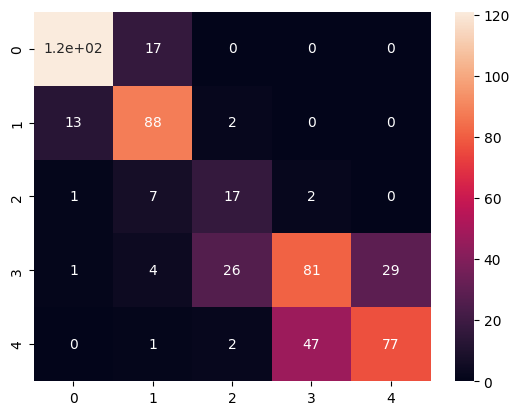

In [12]:
import seaborn as sns
sns.heatmap(cm, annot=True)